# Example 4: Mixed identical photons

signal wavelength:  1.488 um
idler wavelength:  1.488 um
pump wavelength:  0.744 um
phase mismatch:  168634.41
crystal length: 2.0 cm
FWHM of pump intensity:  132.51 GHz


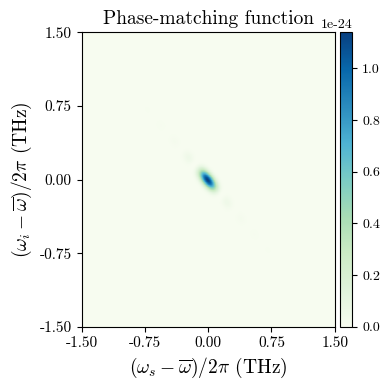

In [1]:
import matplotlib.pyplot as plt
from main import *
import numpy as np

# Define the central frequencies of the two down-converted modes and the pump
omega_s_0 = 1265832916458229.0  # signal mode central frequency
omega_i_0 = 1265832916458229.0  # idler mode central frequency
omega_p_0 = omega_s_0 + omega_i_0  # pump mode central frequency

# Calculate the corresponding wavelengths in micrometers
lambda_s_0 = twopi * speed_of_light * 1e6 / omega_s_0
lambda_i_0 = twopi * speed_of_light * 1e6 / omega_i_0
lambda_p_0 = twopi * speed_of_light * 1e6 / omega_p_0

print(f"signal wavelength: {lambda_s_0: .3f} um")
print(f"idler wavelength: {lambda_i_0: .3f} um")
print(f"pump wavelength: {lambda_p_0: .3f} um")
##### Set wave-numbers using the index of refraction calculated from the Sellmeier equation. Here we use parameters given on the United Crystals website: https://www.unitedcrystals.com/KTPProp.html
# create a Sellmeier class along the y- and z-axis
sel_y = Sellmeier(3.0065, 0.03901, 0.04547, 0.01408)
sel_z = Sellmeier(3.3134, 0.05694, 0.05658, 0.01692)


# define the phase-mismatch which takes the sellmeier class as an input
def phase_mismatch(ws, wi):
    k_s = wave_number(sel_z, ws)
    k_i = wave_number(sel_y, wi)
    k_p = wave_number(sel_y, ws + wi)
    return k_s + k_i - k_p


delta_k_0 = phase_mismatch(omega_s_0, omega_i_0)
print(f'phase mismatch: {delta_k_0: .2f}')
# set frequency range
frequency_width = twopi * 3 * 1e12

dw_s = frequency_width / 1000
dw_i = frequency_width / 1000

ws_range = omega_s_0 + np.arange(- frequency_width / 2, frequency_width / 2 + dw_s, dw_s)
wi_range = omega_i_0 + np.arange(- frequency_width / 2, frequency_width / 2 + dw_i, dw_i)

WS_range, WI_range = np.meshgrid(ws_range, wi_range)

#calculate phase-missmatch. Here we subtract the zeroth order phase-mismatch which would be the result of periodicaly poling the material
delta_k = phase_mismatch(WS_range, WI_range) - delta_k_0
# set crystal length in , 
crystal_length = 2e-2  #crystal length in meters
print(f'crystal length: {crystal_length * 1e2} cm')

# set phase-matching function
phase_matching_function = np.sinc(
    crystal_length * delta_k / 2 / np.pi)  # divide by pi because of numpy sinc definition
# set effective bandwidth of pump
sigma_p = 5e11
print(f'FWHM of pump intensity: {2 * np.sqrt(np.log(2)) * sigma_p * 1e-9 / twopi: .2f} GHz')


def pump(ws, wi):
    return (1 / (sigma_p ** 2 * np.pi)) ** 0.25 * np.exp(-(ws + wi - omega_p_0) ** 2 / 2 / sigma_p ** 2)


# evaluate pump amplitude
alpha = pump(WS_range, WI_range)

# set normalized joint spectral amplitude
jsa = alpha * phase_matching_function / np.sqrt(
    np.sum(np.abs(alpha * phase_matching_function) ** 2) * dw_s * dw_i)

# check range of frequencies by plotting the jsa

ticks_s = np.linspace(np.round(np.min((ws_range - omega_s_0) * 1e-12 / twopi), 2),
                      np.round(np.max((ws_range - omega_s_0) * 1e-12 / twopi), 2),
                      5)

ticks_i = np.linspace(np.round(np.min((wi_range - omega_i_0) * 1e-12 / twopi), 2),
                      np.round(np.max((wi_range - omega_i_0) * 1e-12 / twopi), 2),
                      5)

jsi = np.abs(jsa) ** 2

cmap = 'GnBu'
fig, ax = plt.subplots(figsize=(4, 4))
im0 = ax.pcolormesh((WS_range - omega_s_0) * 1e-12 / twopi,
                    (WI_range - omega_i_0) * 1e-12 / twopi,
                    jsi,
                    #shading='gouraud',
                    #shading='flat',
                    vmin=jsi.min(),
                    vmax=jsi.max(),
                    cmap=cmap)
ax.set_xlabel(r"$(\omega_s - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax.set_ylabel(r"$(\omega_i - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax.set_title(r"Phase-matching function", fontsize=fs)
ax.tick_params(axis='both', labelsize=ts)
ax.set_yticks(ticks_s)
ax.set_xticks(ticks_i)
plt.colorbar(im0, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
plt.tight_layout()
plt.show()

Check normalization:  1.00
Purity:  0.68
Schmidt number:  1.47


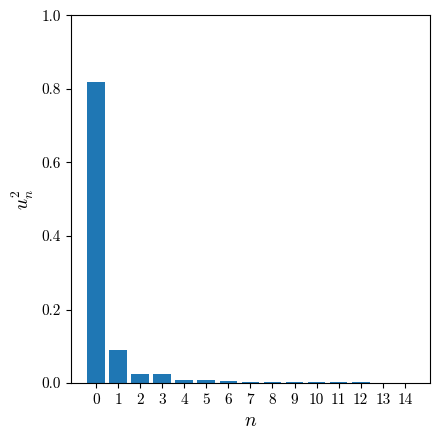

In [2]:
# compute singular-value-decomposition of jsa
U, S, Vh = np.linalg.svd(jsa)

# set the normalized Schmidt amplitudes
u_n = S * dw_s
print(f'Check normalization: {np.sum(u_n ** 2): .2f}')

# calculate the purity 
P = np.sum(u_n ** 4)
#calculate Schmidt number
K = 1 / P
print(f'Purity: {P: .2f}')
print(f'Schmidt number: {K: .2f}')

# set normalized Schmidt modes
mu_n = U.T / np.sqrt(dw_s)
nu_n = np.conj(Vh) / np.sqrt(dw_i)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.bar(range(len(u_n))[0:15], u_n[0:15] ** 2)

ax.set_ylabel(r"$u_n^2$", fontsize=fs)
ax.set_xlabel(r"$n$", fontsize=fs)
ax.tick_params(axis='both', labelsize=ts)
ax.set_ylim(0, 1)
ax.set_xticks(range(len(u_n))[0:15])

plt.tight_layout()
# fig.savefig('figures/fig5.png', dpi=300, bbox_inches='tight')
plt.show(fig)

In [3]:
#calculate coincidence probability
@np.vectorize
def coincidence_mix(delay):
    phase = np.exp(1j * ws_range * delay)
    s = 0
    for i in range(25):
        for j in range(25):
            s += u_n[i] ** 2 * u_n[j] ** 2 * np.abs(np.sum(mu_n[i] * np.conj(mu_n[j] * dw_s) * phase)) ** 2
    return 1 / 2 - 1 / 2 * s


delay_range_mix = np.linspace(-10e-12, 10e-12, 200)
p_mix = coincidence_mix(delay_range_mix)

[-10.  -5.   0.   5.  10.]


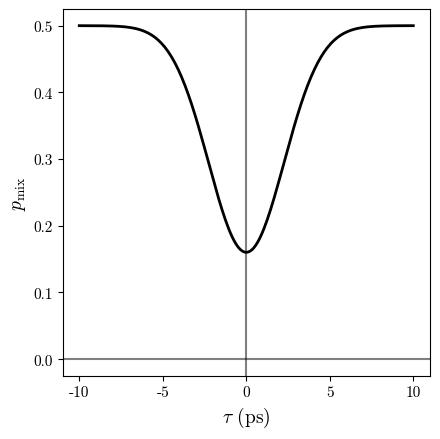

In [4]:
# plot joint spectral amplitude and coincidence probability

ticks_d_mix = np.round(np.linspace(np.min(delay_range_mix * 1e12), np.max(delay_range_mix * 1e12), 5), 2)
print(ticks_d_mix)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(delay_range_mix * 1e12, p_mix,
        linewidth=2,
        color='black')
ax.set_xlabel(r"$\tau$ (ps)", fontsize=fs)
ax.set_ylabel(r"$p_\mathrm{mix}$", fontsize=fs)
ax.tick_params(axis='both', labelsize=ts)
ax.axhline(0, color='black', alpha=0.5)
ax.axvline(0, color='black', alpha=0.5)
ax.set_xticks(ticks_d_mix)

plt.tight_layout()
fig.savefig('figures/fig5.png', dpi=300, bbox_inches='tight')
plt.show(fig)

In [5]:
# calculate the visibility
V = (np.max(p_mix) - np.min(p_mix)) / np.max(p_mix)
print(f'Purity: {P: .2f}')
print(f'Visibility: {V: .2f}')

Purity:  0.68
Visibility:  0.68
